In [1]:
from pyscf import gto, scf, mcscf, fci
from pyscf.fci import cistring
import openfermion as of
import cirq
from openfermion.circuits import trotter
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import scipy
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf

 done


  Preparing metadata (pyproject.toml) ... -

 done


  Using cached cirq_core-1.4.1-py3-none-any.whl.metadata (1.8 kB)
  Using cached deprecation-2.1.0-py2.py3-none-any.whl.metadata (4.6 kB)


  Using cached PubChemPy-1.0.4-py3-none-any.whl


  Using cached sympy-1.12.1-py3-none-any.whl.metadata (12 kB)
  Using cached duet-0.2.9-py3-none-any.whl.metadata (2.3 kB)


  Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl.metadata (10 kB)


  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)


Using cached cirq_core-1.4.1-py3-none-any.whl (1.9 MB)
Using cached deprecation-2.1.0-py2.py3-none-any.whl (11 kB)
Using cached sympy-1.12.1-py3-none-any.whl (5.7 MB)
Using cached duet-0.2.9-py3-none-any.whl (29 kB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl (29 kB)


 \

 |

 /

 done
  Created wheel for openfermion: filename=openfermion-1.7.0.dev0-py3-none-any.whl size=1209626 sha256=c465373d77b9e9b4e01d7044a26013e6b7ea3d2d367cc5f664078a49e3d96e6a
  Stored in directory: /tmpfs/tmp/pip-ephem-wheel-cache-1i0mk48_/wheels/7a/93/a6/5746203c4afd3b6e8d40a4edb587d608c51290286c5680f422


Successfully built openfermion


In [3]:
# Set Hamiltonian parameters for LiH simulation in active space.
diatomic_bond_length = 1.45
geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
basis = 'sto-3g'
multiplicity = 1
active_space_start = 1
active_space_stop = 3

# Generate and populate instance of MolecularData.
molecule = of.MolecularData(geometry, basis, multiplicity, description="1.45")
molecule.load()

# Get the Hamiltonian in an active space.
molecular_hamiltonian = molecule.get_molecular_hamiltonian(
    occupied_indices=range(active_space_start),
    active_indices=range(active_space_start, active_space_stop))

In [38]:
n_steps = 1
t=1.

final_rank = 2

# Initialize circuit qubits in a line.
n_qubits = of.count_qubits(molecular_hamiltonian)
qubits = cirq.LineQubit.range(n_qubits+1)

# Compile the low rank Trotter step using OpenFermion.
custom_algorithm = trotter.algorithms.low_rank.ControlledAsymmetricLowRankTrotterStep(hamiltonian=molecular_hamiltonian,
                                                                                      final_rank=final_rank)
circuit = cirq.Circuit(
    trotter.simulate_trotter(
            qubits, molecular_hamiltonian,
            time=time, omit_final_swaps=True,
            algorithm=custom_algorithm),
    strategy=cirq.InsertStrategy.EARLIEST)

# Print circuit.
cirq.drop_negligible_operations(circuit)
gateset = cirq.CZTargetGateset(allow_partial_czs=False)
cz_circuit = cirq.optimize_for_target_gateset(circuit, gateset=gateset)

print("Circuit compile time (to CZ gate set)")
depth = len(cirq.Circuit(cz_circuit.all_operations()))
print("Circuit Depth: "+str(depth))
print("-------------------------------------")
"""
    Get single and two qubit gates
"""
single_qubit_gates = 0
cz_gates = 0

for ops in cz_circuit.all_operations():
    
    if isinstance(ops.gate, cirq.PhasedXZGate):
        single_qubit_gates += 1
    
    else:
        cz_gates += 1
        
print("Single qubit gate count: " + str(single_qubit_gates))
print("CZ gate count: " + str(cz_gates))
print(" ")

AttributeError: 'ControlledAsymmetricLowRankTrotterStep' object has no attribute 'supported_types'

In [33]:
cirq.drop_negligible_operations(cz_circuit)
print(cz_circuit.to_text_diagram(transpose=True))

0                                1                                2                               3
│                                │                                │                               │
│                                PhXZ(a=0.25,x=-0.5,z=0)          PhXZ(a=0.25,x=0.5,z=5.55e-17)   │
│                                │                                │                               │
│                                @────────────────────────────────@                               │
│                                │                                │                               │
│                                PhXZ(a=0.25,x=0.5,z=5.55e-17)    PhXZ(a=0.25,x=-0.5,z=0)         │
│                                │                                │                               │
│                                @────────────────────────────────@                               │
│                                │                                │                               │


In [34]:
# Compile the low rank Trotter step using OpenFermion.
n=4
ancilla = cirq.NamedQubit("ancilla")

custom_algorithm = trotter.LowRankTrotterAlgorithm(final_rank=final_rank)
U = cirq.ControlledGate(cz_circuit)

CU =cirq.ControlledGate(U).on(qubits+[ancilla])

ValueError: Wrong number of qubits for <cirq.ControlledGate(sub_gate=cirq.Circuit([
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.2500000000000001, x_exponent=0.25, z_exponent=-0.2499999999999999).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999978, x_exponent=0.5, z_exponent=-1.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-4.440892098500626e-16, x_exponent=0.040653073128158905, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-4.440892098500626e-16, x_exponent=0.040653073128158905, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-1.1102230246251565e-16, x_exponent=0.5, z_exponent=-0.6630467843791874).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999998, x_exponent=-0.040653073128158905, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999998, x_exponent=-0.040653073128158905, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.6694729864610895, x_exponent=0.5, z_exponent=-0.8305270135389105).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=-0.663046784379187).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.5, z_exponent=-0.83052701353891).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.49999999999999956, x_exponent=0.025514754076496844, z_exponent=4.440892098500626e-16).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.49999999999999956, x_exponent=0.025514754076496844, z_exponent=4.440892098500626e-16).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-2.220446049250313e-16, x_exponent=0.025514754076496844, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=-2.220446049250313e-16, x_exponent=-0.025514754076496844, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.25, z_exponent=0.25).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.3771442498958102, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.7499999999999998, x_exponent=0.62714424989581, z_exponent=0.37285575010419025).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.12285575010418981, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.3771442498958102, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.12285575010418981, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.3771442498958104, x_exponent=-0.5724193866415113, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.6633539432165654, x_exponent=1, z_exponent=0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.8771442498958104, x_exponent=0.5, z_exponent=-0.07241938664151171).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.25, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.5332353690784573, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.25, x_exponent=0.5, z_exponent=-0.0332353690784577).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.039154862774596566, x_exponent=0.49999999999999994, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.9940805063038605, x_exponent=0.5000000000000002, z_exponent=-0.0450743564707361).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4608451372254032, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.039154862774596566, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4608451372254032, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.039154862774596566, x_exponent=0.5490600147112304, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.04906001471122989, x_exponent=0.5, z_exponent=0.4509399852887701).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.9608451372254034, x_exponent=0.5882148774858269, z_exponent=-0.46084513722540343).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5490600147112304, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.5490600147112304, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=0.4177046162103127).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.21938435174249826, z_exponent=-0.8296756629687323).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.27453000735561517, x_exponent=1, z_exponent=0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.5, z_exponent=-0.1214794013527416).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.3296756629687323, x_exponent=-0.4509399852887697, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.8296756629687323, x_exponent=0.4999999999999998, z_exponent=-0.6214794013527416).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.917704616210314, x_exponent=0.5, z_exponent=0.4177046162103131).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999991, x_exponent=-0.4750315452579051, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.4750315452579051, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999991, x_exponent=0.5, z_exponent=1.1102230246251565e-15).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.4750315452579051, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.4750315452579051, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.25, z_exponent=0.25).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4829327755837052, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.2500000000000001, x_exponent=0.7670672244162948, z_exponent=0.23293277558370562).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.017067224416294824, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48293277558370473, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.017067224416294824, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.4829327755837047, x_exponent=0.520481277059991, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.9829327755837047, x_exponent=0.5, z_exponent=0.9795187229400095).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.7226921370537094, x_exponent=1, z_exponent=0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4878791480144326, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.48787914801443266, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=0.5094920601785325, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=-0.5094920601785324).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985571779, x_exponent=0.9942762265816314, z_exponent=0.9962317132398453).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48411086125426905, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.015889138745730946, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48411086125426905, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.015889138745730946, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48411086125426905, x_exponent=0.5139430812371812, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788013, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.506208259480607, x_exponent=0.5, z_exponent=0.5139430812371812).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.515889138745731, x_exponent=0.4980539424914503, z_exponent=-0.48411086125426905).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.479848659282212, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788013, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.479848659282212, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788013, x_exponent=-0.5139430812371812, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5139430812371812, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=-0.5065381958228099).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788235, x_exponent=0.7449447979893136, z_exponent=0.2689982832478677).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=-0.48605691876281854).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=-0.9955489789413514).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        (cirq.CZ**-1.0).on(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.28914962396565613, x_exponent=0.4860569187628188, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        (cirq.CZ**-1.0).on(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.2891496239656559, x_exponent=0.2936006450243056, z_exponent=-0.7891496239656566).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=0.49346180417718966).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.45880062753744, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.45880062753744, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-1.0, x_exponent=0.5, z_exponent=-1.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.45880062753744, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999998, x_exponent=-0.45880062753744, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=-1.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.040653073128158905, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.040653073128158905, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-1.0, x_exponent=0.4999999999999998, z_exponent=0.33695321562081304).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.49999999999999956, x_exponent=0.040653073128158905, z_exponent=4.440892098500626e-16).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999998, x_exponent=-0.040653073128158905, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.6694729864610895, x_exponent=0.5, z_exponent=-0.8305270135389105).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5000000000000002, x_exponent=0.4999999999999998, z_exponent=-0.6630467843791865).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.5, z_exponent=0.1694729864610902).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.49999999999999956, x_exponent=0.025514754076496844, z_exponent=4.440892098500626e-16).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.49999999999999956, x_exponent=0.025514754076496844, z_exponent=4.440892098500626e-16).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-2.220446049250313e-16, x_exponent=0.025514754076496844, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=-2.220446049250313e-16, x_exponent=-0.025514754076496844, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.25, z_exponent=0.25).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.3771442498958102, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.7499999999999998, x_exponent=0.62714424989581, z_exponent=0.37285575010419025).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.12285575010418981, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.3771442498958102, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.12285575010418981, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.3771442498958104, x_exponent=-0.5724193866415113, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.6633539432165654, x_exponent=1, z_exponent=0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.8771442498958104, x_exponent=0.5, z_exponent=-0.07241938664151171).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.25, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.5332353690784573, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.25, x_exponent=0.5, z_exponent=-0.0332353690784577).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.039154862774596566, x_exponent=0.49999999999999994, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.9940805063038605, x_exponent=0.5000000000000002, z_exponent=-0.0450743564707361).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4608451372254032, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.039154862774596566, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4608451372254032, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.039154862774596566, x_exponent=0.5490600147112304, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.04906001471122989, x_exponent=0.5, z_exponent=0.4509399852887701).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.9608451372254034, x_exponent=0.5882148774858269, z_exponent=-0.46084513722540343).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5490600147112304, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.5490600147112304, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=0.4177046162103127).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.21938435174249826, z_exponent=-0.8296756629687323).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.27453000735561517, x_exponent=1, z_exponent=0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.5, z_exponent=-0.1214794013527416).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.3296756629687323, x_exponent=-0.4509399852887697, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.8296756629687323, x_exponent=0.4999999999999998, z_exponent=-0.6214794013527416).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.917704616210314, x_exponent=0.5, z_exponent=0.4177046162103131).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999991, x_exponent=-0.4750315452579051, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.4750315452579051, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999991, x_exponent=0.5, z_exponent=1.1102230246251565e-15).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.4750315452579051, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.4750315452579051, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.25, z_exponent=0.25).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4829327755837052, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.2500000000000001, x_exponent=0.7670672244162948, z_exponent=0.23293277558370562).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.017067224416294824, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48293277558370473, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.017067224416294824, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.4829327755837047, x_exponent=0.520481277059991, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.9829327755837047, x_exponent=0.5, z_exponent=0.9795187229400095).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.7226921370537094, x_exponent=1, z_exponent=0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4878791480144326, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.48787914801443266, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=0.5094920601785325, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=-0.5094920601785324).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985571779, x_exponent=0.9942762265816314, z_exponent=0.9962317132398453).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48411086125426905, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.015889138745730946, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48411086125426905, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.015889138745730946, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48411086125426905, x_exponent=0.5139430812371812, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788013, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.506208259480607, x_exponent=0.5, z_exponent=0.5139430812371812).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.515889138745731, x_exponent=0.4980539424914503, z_exponent=-0.48411086125426905).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.479848659282212, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788013, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.479848659282212, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788013, x_exponent=-0.5139430812371812, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5139430812371812, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=-0.5065381958228099).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788235, x_exponent=0.7449447979893136, z_exponent=0.2689982832478677).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=-0.48605691876281854).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=-0.9955489789413514).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        (cirq.CZ**-1.0).on(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.28914962396565613, x_exponent=0.4860569187628188, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        (cirq.CZ**-1.0).on(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.2891496239656559, x_exponent=0.2936006450243056, z_exponent=-0.7891496239656566).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=0.49346180417718966).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.45880062753744, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.45880062753744, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-1.0, x_exponent=0.5, z_exponent=-1.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.45880062753744, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999998, x_exponent=-0.45880062753744, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=-1.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.040653073128158905, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.040653073128158905, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-1.0, x_exponent=0.4999999999999998, z_exponent=0.33695321562081304).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.49999999999999956, x_exponent=0.040653073128158905, z_exponent=4.440892098500626e-16).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999998, x_exponent=-0.040653073128158905, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.6694729864610895, x_exponent=0.5, z_exponent=-0.8305270135389105).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5000000000000002, x_exponent=0.4999999999999998, z_exponent=-0.6630467843791865).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.5, z_exponent=0.1694729864610902).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.49999999999999956, x_exponent=0.025514754076496844, z_exponent=4.440892098500626e-16).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.49999999999999956, x_exponent=0.025514754076496844, z_exponent=4.440892098500626e-16).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-2.220446049250313e-16, x_exponent=0.025514754076496844, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=-2.220446049250313e-16, x_exponent=-0.025514754076496844, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.25, z_exponent=0.25).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.3771442498958102, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.7499999999999998, x_exponent=0.62714424989581, z_exponent=0.37285575010419025).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.12285575010418981, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.3771442498958102, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.12285575010418981, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.3771442498958104, x_exponent=-0.5724193866415113, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.6633539432165654, x_exponent=1, z_exponent=0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.8771442498958104, x_exponent=0.5, z_exponent=-0.07241938664151171).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.25, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.5332353690784573, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.25, x_exponent=0.5, z_exponent=-0.0332353690784577).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.039154862774596566, x_exponent=0.49999999999999994, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.9940805063038605, x_exponent=0.5000000000000002, z_exponent=-0.0450743564707361).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4608451372254032, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.039154862774596566, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4608451372254032, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.039154862774596566, x_exponent=0.5490600147112304, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.04906001471122989, x_exponent=0.5, z_exponent=0.4509399852887701).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.9608451372254034, x_exponent=0.5882148774858269, z_exponent=-0.46084513722540343).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5490600147112304, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.5490600147112304, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=0.4177046162103127).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.21938435174249826, z_exponent=-0.8296756629687323).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.27453000735561517, x_exponent=1, z_exponent=0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.5, z_exponent=-0.1214794013527416).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.3296756629687323, x_exponent=-0.4509399852887697, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.8296756629687323, x_exponent=0.4999999999999998, z_exponent=-0.6214794013527416).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.917704616210314, x_exponent=0.5, z_exponent=0.4177046162103131).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999991, x_exponent=-0.4750315452579051, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.4750315452579051, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999991, x_exponent=0.5, z_exponent=1.1102230246251565e-15).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.4750315452579051, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.4750315452579051, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.25, z_exponent=0.25).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4829327755837052, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.2500000000000001, x_exponent=0.7670672244162948, z_exponent=0.23293277558370562).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.017067224416294824, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48293277558370473, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.017067224416294824, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.4829327755837047, x_exponent=0.520481277059991, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.9829327755837047, x_exponent=0.5, z_exponent=0.9795187229400095).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.7226921370537094, x_exponent=1, z_exponent=0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4878791480144326, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.48787914801443266, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=0.5094920601785325, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=-0.5094920601785324).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985571779, x_exponent=0.9942762265816314, z_exponent=0.9962317132398453).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48411086125426905, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.015889138745730946, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48411086125426905, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.015889138745730946, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48411086125426905, x_exponent=0.5139430812371812, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788013, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.506208259480607, x_exponent=0.5, z_exponent=0.5139430812371812).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.515889138745731, x_exponent=0.4980539424914503, z_exponent=-0.48411086125426905).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.479848659282212, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788013, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.479848659282212, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788013, x_exponent=-0.5139430812371812, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5139430812371812, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=-0.5065381958228099).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788235, x_exponent=0.7449447979893136, z_exponent=0.2689982832478677).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=-0.48605691876281854).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=-0.9955489789413514).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        (cirq.CZ**-1.0).on(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.28914962396565613, x_exponent=0.4860569187628188, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        (cirq.CZ**-1.0).on(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.7108503760343436, x_exponent=0.7063993549756948, z_exponent=0.21085037603434342).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=0.49346180417718966).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.45880062753744, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.45880062753744, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999998, x_exponent=-0.45880062753744, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.45880062753744, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-1.0, x_exponent=0.75, z_exponent=0.75).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999978, x_exponent=0.5, z_exponent=-1.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
]), num_controls=2)>. Expected 6 qubits but got <([cirq.NamedQubit('q0'), cirq.NamedQubit('q1'), cirq.NamedQubit('q2'), cirq.NamedQubit('q3'), cirq.NamedQubit('ancilla')],)>.

In [21]:
hadamard_test_circuit(cz_circuit)

ValueError: Wrong number of qubits for <cirq.ControlledGate(sub_gate=cirq.Circuit([
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.2500000000000001, x_exponent=0.25, z_exponent=-0.2499999999999999).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999978, x_exponent=0.5, z_exponent=-1.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-4.440892098500626e-16, x_exponent=0.040653073128158905, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-4.440892098500626e-16, x_exponent=0.040653073128158905, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-1.1102230246251565e-16, x_exponent=0.5, z_exponent=-0.6630467843791874).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999998, x_exponent=-0.040653073128158905, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999998, x_exponent=-0.040653073128158905, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.6694729864610895, x_exponent=0.5, z_exponent=-0.8305270135389105).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=-0.663046784379187).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.5, z_exponent=-0.83052701353891).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.49999999999999956, x_exponent=0.025514754076496844, z_exponent=4.440892098500626e-16).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.49999999999999956, x_exponent=0.025514754076496844, z_exponent=4.440892098500626e-16).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-2.220446049250313e-16, x_exponent=0.025514754076496844, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=-2.220446049250313e-16, x_exponent=-0.025514754076496844, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.25, z_exponent=0.25).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.3771442498958102, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.7499999999999998, x_exponent=0.62714424989581, z_exponent=0.37285575010419025).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.12285575010418981, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.3771442498958102, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.12285575010418981, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.3771442498958104, x_exponent=-0.5724193866415113, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.6633539432165654, x_exponent=1, z_exponent=0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.8771442498958104, x_exponent=0.5, z_exponent=-0.07241938664151171).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.25, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.5332353690784573, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.25, x_exponent=0.5, z_exponent=-0.0332353690784577).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.039154862774596566, x_exponent=0.49999999999999994, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.9940805063038605, x_exponent=0.5000000000000002, z_exponent=-0.0450743564707361).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4608451372254032, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.039154862774596566, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4608451372254032, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.039154862774596566, x_exponent=0.5490600147112304, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.04906001471122989, x_exponent=0.5, z_exponent=0.4509399852887701).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.9608451372254034, x_exponent=0.5882148774858269, z_exponent=-0.46084513722540343).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5490600147112304, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.5490600147112304, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=0.4177046162103127).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.21938435174249826, z_exponent=-0.8296756629687323).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.27453000735561517, x_exponent=1, z_exponent=0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.5, z_exponent=-0.1214794013527416).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.3296756629687323, x_exponent=-0.4509399852887697, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.8296756629687323, x_exponent=0.4999999999999998, z_exponent=-0.6214794013527416).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.917704616210314, x_exponent=0.5, z_exponent=0.4177046162103131).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999991, x_exponent=-0.4750315452579051, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.4750315452579051, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999991, x_exponent=0.5, z_exponent=1.1102230246251565e-15).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.4750315452579051, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.4750315452579051, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.25, z_exponent=0.25).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4829327755837052, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.2500000000000001, x_exponent=0.7670672244162948, z_exponent=0.23293277558370562).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.017067224416294824, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48293277558370473, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.017067224416294824, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.4829327755837047, x_exponent=0.520481277059991, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.9829327755837047, x_exponent=0.5, z_exponent=0.9795187229400095).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.7226921370537094, x_exponent=1, z_exponent=0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4878791480144326, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.48787914801443266, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=0.5094920601785325, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=-0.5094920601785324).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985571779, x_exponent=0.9942762265816314, z_exponent=0.9962317132398453).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48411086125426905, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.015889138745730946, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48411086125426905, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.015889138745730946, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48411086125426905, x_exponent=0.5139430812371812, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788013, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.506208259480607, x_exponent=0.5, z_exponent=0.5139430812371812).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.515889138745731, x_exponent=0.4980539424914503, z_exponent=-0.48411086125426905).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.479848659282212, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788013, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.479848659282212, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788013, x_exponent=-0.5139430812371812, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5139430812371812, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=-0.5065381958228099).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788235, x_exponent=0.7449447979893136, z_exponent=0.2689982832478677).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=-0.48605691876281854).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=-0.9955489789413514).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        (cirq.CZ**-1.0).on(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.28914962396565613, x_exponent=0.4860569187628188, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        (cirq.CZ**-1.0).on(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.2891496239656559, x_exponent=0.2936006450243056, z_exponent=-0.7891496239656566).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=0.49346180417718966).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.45880062753744, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.45880062753744, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-1.0, x_exponent=0.5, z_exponent=-1.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.45880062753744, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999998, x_exponent=-0.45880062753744, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=-1.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.040653073128158905, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.040653073128158905, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-1.0, x_exponent=0.4999999999999998, z_exponent=0.33695321562081304).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.49999999999999956, x_exponent=0.040653073128158905, z_exponent=4.440892098500626e-16).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999998, x_exponent=-0.040653073128158905, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.6694729864610895, x_exponent=0.5, z_exponent=-0.8305270135389105).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5000000000000002, x_exponent=0.4999999999999998, z_exponent=-0.6630467843791865).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.5, z_exponent=0.1694729864610902).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.49999999999999956, x_exponent=0.025514754076496844, z_exponent=4.440892098500626e-16).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.49999999999999956, x_exponent=0.025514754076496844, z_exponent=4.440892098500626e-16).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-2.220446049250313e-16, x_exponent=0.025514754076496844, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=-2.220446049250313e-16, x_exponent=-0.025514754076496844, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.25, z_exponent=0.25).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.3771442498958102, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.7499999999999998, x_exponent=0.62714424989581, z_exponent=0.37285575010419025).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.12285575010418981, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.3771442498958102, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.12285575010418981, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.3771442498958104, x_exponent=-0.5724193866415113, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.6633539432165654, x_exponent=1, z_exponent=0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.8771442498958104, x_exponent=0.5, z_exponent=-0.07241938664151171).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.25, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.5332353690784573, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.25, x_exponent=0.5, z_exponent=-0.0332353690784577).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.039154862774596566, x_exponent=0.49999999999999994, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.9940805063038605, x_exponent=0.5000000000000002, z_exponent=-0.0450743564707361).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4608451372254032, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.039154862774596566, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4608451372254032, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.039154862774596566, x_exponent=0.5490600147112304, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.04906001471122989, x_exponent=0.5, z_exponent=0.4509399852887701).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.9608451372254034, x_exponent=0.5882148774858269, z_exponent=-0.46084513722540343).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5490600147112304, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.5490600147112304, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=0.4177046162103127).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.21938435174249826, z_exponent=-0.8296756629687323).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.27453000735561517, x_exponent=1, z_exponent=0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.5, z_exponent=-0.1214794013527416).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.3296756629687323, x_exponent=-0.4509399852887697, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.8296756629687323, x_exponent=0.4999999999999998, z_exponent=-0.6214794013527416).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.917704616210314, x_exponent=0.5, z_exponent=0.4177046162103131).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999991, x_exponent=-0.4750315452579051, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.4750315452579051, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999991, x_exponent=0.5, z_exponent=1.1102230246251565e-15).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.4750315452579051, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.4750315452579051, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.25, z_exponent=0.25).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4829327755837052, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.2500000000000001, x_exponent=0.7670672244162948, z_exponent=0.23293277558370562).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.017067224416294824, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48293277558370473, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.017067224416294824, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.4829327755837047, x_exponent=0.520481277059991, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.9829327755837047, x_exponent=0.5, z_exponent=0.9795187229400095).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.7226921370537094, x_exponent=1, z_exponent=0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4878791480144326, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.48787914801443266, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=0.5094920601785325, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=-0.5094920601785324).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985571779, x_exponent=0.9942762265816314, z_exponent=0.9962317132398453).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48411086125426905, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.015889138745730946, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48411086125426905, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.015889138745730946, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48411086125426905, x_exponent=0.5139430812371812, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788013, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.506208259480607, x_exponent=0.5, z_exponent=0.5139430812371812).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.515889138745731, x_exponent=0.4980539424914503, z_exponent=-0.48411086125426905).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.479848659282212, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788013, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.479848659282212, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788013, x_exponent=-0.5139430812371812, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5139430812371812, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=-0.5065381958228099).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788235, x_exponent=0.7449447979893136, z_exponent=0.2689982832478677).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=-0.48605691876281854).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=-0.9955489789413514).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        (cirq.CZ**-1.0).on(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.28914962396565613, x_exponent=0.4860569187628188, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        (cirq.CZ**-1.0).on(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.2891496239656559, x_exponent=0.2936006450243056, z_exponent=-0.7891496239656566).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=0.49346180417718966).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.45880062753744, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.45880062753744, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-1.0, x_exponent=0.5, z_exponent=-1.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.45880062753744, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999998, x_exponent=-0.45880062753744, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=-1.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.040653073128158905, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.040653073128158905, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-1.0, x_exponent=0.4999999999999998, z_exponent=0.33695321562081304).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.49999999999999956, x_exponent=0.040653073128158905, z_exponent=4.440892098500626e-16).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999998, x_exponent=-0.040653073128158905, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.6694729864610895, x_exponent=0.5, z_exponent=-0.8305270135389105).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5000000000000002, x_exponent=0.4999999999999998, z_exponent=-0.6630467843791865).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.5, z_exponent=0.1694729864610902).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.49999999999999956, x_exponent=0.025514754076496844, z_exponent=4.440892098500626e-16).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.49999999999999956, x_exponent=0.025514754076496844, z_exponent=4.440892098500626e-16).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-2.220446049250313e-16, x_exponent=0.025514754076496844, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=-2.220446049250313e-16, x_exponent=-0.025514754076496844, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.25, z_exponent=0.25).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.3771442498958102, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.7499999999999998, x_exponent=0.62714424989581, z_exponent=0.37285575010419025).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.12285575010418981, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.3771442498958102, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.12285575010418981, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.3771442498958104, x_exponent=-0.5724193866415113, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.6633539432165654, x_exponent=1, z_exponent=0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.8771442498958104, x_exponent=0.5, z_exponent=-0.07241938664151171).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.25, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.5332353690784573, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.25, x_exponent=0.5, z_exponent=-0.0332353690784577).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.039154862774596566, x_exponent=0.49999999999999994, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.9940805063038605, x_exponent=0.5000000000000002, z_exponent=-0.0450743564707361).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4608451372254032, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.039154862774596566, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4608451372254032, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.039154862774596566, x_exponent=0.5490600147112304, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.04906001471122989, x_exponent=0.5, z_exponent=0.4509399852887701).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.9608451372254034, x_exponent=0.5882148774858269, z_exponent=-0.46084513722540343).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5490600147112304, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.5490600147112304, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=0.4177046162103127).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.21938435174249826, z_exponent=-0.8296756629687323).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.27453000735561517, x_exponent=1, z_exponent=0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.5, x_exponent=0.5, z_exponent=-0.1214794013527416).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.3296756629687323, x_exponent=-0.4509399852887697, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.8296756629687323, x_exponent=0.4999999999999998, z_exponent=-0.6214794013527416).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.917704616210314, x_exponent=0.5, z_exponent=0.4177046162103131).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999991, x_exponent=-0.4750315452579051, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.4750315452579051, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999991, x_exponent=0.5, z_exponent=1.1102230246251565e-15).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.4750315452579051, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.4750315452579051, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.25, z_exponent=0.25).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4829327755837052, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.2500000000000001, x_exponent=0.7670672244162948, z_exponent=0.23293277558370562).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.017067224416294824, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48293277558370473, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.017067224416294824, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.4829327755837047, x_exponent=0.520481277059991, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.9829327755837047, x_exponent=0.5, z_exponent=0.9795187229400095).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.7226921370537094, x_exponent=1, z_exponent=0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4878791480144326, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.48787914801443266, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985567338, x_exponent=0.5094920601785325, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=-0.5094920601785324).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.012120851985571779, x_exponent=0.9942762265816314, z_exponent=0.9962317132398453).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48411086125426905, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.015889138745730946, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48411086125426905, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.015889138745730946, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.48411086125426905, x_exponent=0.5139430812371812, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788013, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.506208259480607, x_exponent=0.5, z_exponent=0.5139430812371812).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.515889138745731, x_exponent=0.4980539424914503, z_exponent=-0.48411086125426905).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.479848659282212, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788013, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(0)),
        cirq.CZ(cirq.LineQubit(3), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=-0.479848659282212, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788013, x_exponent=-0.5139430812371812, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5139430812371812, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=-0.5065381958228099).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.020151340717788235, x_exponent=0.7449447979893136, z_exponent=0.2689982832478677).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=-0.48605691876281854).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=-0.9955489789413514).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        (cirq.CZ**-1.0).on(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.28914962396565613, x_exponent=0.4860569187628188, z_exponent=0.0).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        (cirq.CZ**-1.0).on(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=-0.7108503760343436, x_exponent=0.7063993549756948, z_exponent=0.21085037603434342).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.0, z_exponent=0.49346180417718966).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=-0.45880062753744, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.45880062753744, z_exponent=1.1102230246251565e-16).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(0)),
        cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.5, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.4999999999999998, x_exponent=-0.45880062753744, z_exponent=0.0).on(cirq.LineQubit(2)),
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=0.45880062753744, z_exponent=0.0).on(cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(2), cirq.LineQubit(3)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.5, x_exponent=-0.5, z_exponent=0.0).on(cirq.LineQubit(3)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=-1.0, x_exponent=0.75, z_exponent=0.75).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999994, x_exponent=0.49999999999999994, z_exponent=5.551115123125783e-17).on(cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.CZ(cirq.LineQubit(1), cirq.LineQubit(2)),
    ),
    cirq.Moment(
        cirq.PhasedXZGate(axis_phase_exponent=0.24999999999999978, x_exponent=0.5, z_exponent=-1.0).on(cirq.LineQubit(1)),
        cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=-0.49999999999999994, z_exponent=0.0).on(cirq.LineQubit(2)),
    ),
]))>. Expected 5 qubits but got <(cirq.LineQubit(0), cirq.LineQubit(1), cirq.LineQubit(2), cirq.LineQubit(3))>.

In [10]:
print(cirq.qasm(cz_circuit))

// Generated from Cirq v1.3.0

OPENQASM 2.0;
include "qelib1.inc";


// Qubits: [q(0), q(1), q(2), q(3)]
qreg q[4];


u3(pi*1.5,pi*1.75,pi*0.25) q[1];
u3(pi*0.5,pi*1.75,pi*0.25) q[2];
cz q[1],q[2];
u3(pi*0.5,pi*1.75,pi*0.25) q[1];
u3(pi*1.5,pi*1.75,pi*0.25) q[2];
cz q[1],q[2];
u3(pi*1.5,pi*1.5,pi*0.5) q[0];
u3(pi*0.25,pi*1.0,pi*0.75) q[1];
u3(pi*0.5,pi*0.75,pi*0.25) q[2];
cz q[0],q[1];
u3(pi*0.0406530731,pi*1.5,pi*0.5) q[0];
u3(pi*0.0406530731,pi*1.5,pi*0.5) q[1];
cz q[0],q[1];
u3(pi*0.5,pi*0.8369532156,pi*0.5) q[0];
u3(pi*1.5,pi*1.5,pi*0.5) q[1];
u3(pi*0.5,0,0) q[3];
u3(pi*1.5,0,0) q[2];
cz q[2],q[3];
u3(pi*1.9593469269,pi*2.0,0) q[2];
u3(pi*1.9593469269,pi*2.0,0) q[3];
cz q[2],q[3];
u3(pi*1.5,0,0) q[0];
u3(pi*0.5,0,pi*1.1694729865) q[1];
u3(pi*0.5,pi*1.3369532156,0) q[2];
u3(pi*0.5,pi*0.1694729865,pi*1.0) q[3];
cz q[0],q[1];
u3(pi*0.0255147541,0,0) q[0];
u3(pi*0.0255147541,0,0) q[1];
cz q[0],q[1];
u3(pi*0.5,0,0) q[0];
u3(pi*1.5,0,0) q[1];
u3(pi*1.5,pi*1.5,pi*0.5) q[3];
u3(pi*1.5,pi*1

In [ ]:
# Initialize a random initial state.
random_seed = 8317
initial_state = openfermion.haar_random_vector(
    2 ** n_qubits, random_seed).astype(np.complex64)

# Numerically compute the correct circuit output.

hamiltonian_sparse = openfermion.get_sparse_operator(molecular_hamiltonian)
exact_state = scipy.sparse.linalg.expm_multiply(
    -1j * time * hamiltonian_sparse, initial_state)

# Trotter step parameters.
n_steps = 3

# Compile the low rank Trotter step using OpenFermion.
qubits = cirq.LineQubit.range(n_qubits)
circuit = cirq.Circuit(
    trotter.simulate_trotter(
            qubits, molecular_hamiltonian,
            time=time, n_steps=n_steps,
            algorithm=trotter.LOW_RANK),
    strategy=cirq.InsertStrategy.EARLIEST)

# Use Cirq simulator to apply circuit.
simulator = cirq.Simulator()
result = simulator.simulate(circuit, qubit_order=qubits, initial_state=initial_state)
simulated_state = result.final_state_vector

# Print final fidelity.
fidelity = abs(np.dot(simulated_state, np.conjugate(exact_state))) ** 2
print('Fidelity with exact result is {}.\n'.format(fidelity))

# Print circuit.
cirq.drop_negligible_operations(circuit)
print(circuit.to_text_diagram(transpose=True))

In order to demonstrate the process of resource estimation, we look at quantum simulation algorithm that was designed to efficiently time evolve fermionic systems [arXiv:1808.02625](https://arxiv.org/abs/1808.02625). Note newer methods exist that further improve the runtime of this algorithm [arXiv:2011.03494](https://arxiv.org/abs/2011.03494).

There are two primary ways in which quantum computers can approximate the unitary operator $U(t) = \exp(-iHt)$. The first is **quantum signal process** and the second is **Trotter-Suzuki products**. For a given quantum simulation/dynamics task, evaluating which of these two techniques is better is an important step in determining a resource efficient quantum algorithm. The algorithm proposed in [arXiv:1808.02625](https://arxiv.org/abs/1808.02625) is the latter type of algorithm. Remarkably, this method has formulas for exact gate count for Clifford + T gate sets.

Let $N_{orb} = N_{occ} + N_{vir}$ be the number of **spin orbitals** of a given molecule where $N_{occ}, N_{vir}$ are the number of occupied and virtual spin orbitals. In the case of the $CAS(18,12)$ active space for cyclic ozone, $N_{orb} = 24$. Let $L$ be the precision parameters *rank*. For a linear nearest neighbor architecture and a gate set using $CX$ or $CZ$ as the entangling gate, the Trotter method at hand requires a number of quantum gates (operations) given by the formula
$N_{gates} = 3 \times \left[ \sum_{\ell=1}^L \frac{N \rho_\ell}{4} + \frac{\rho_\ell^2}{4} - \rho_\ell \right ]$
with circuit depth of $N_{depth} = \sum_{\ell = 1}^L \frac{N}{2} + \frac{3\rho_\ell}{2}$. The parameter $\rho_\ell$ is a more subtle algorithm parameter that scales in expected value as $O(N_{orb})$ for some molecules and $O(\log( N_{orb}))$ for others. The critical precision parameter is rank $L$, for the exact decomposition of time evolution operator we require $L = N_{orb}^2$ and $\rho_\ell = N_{orb}$.

For a Clifford + T gateset, we can calculate the number of $T$ gates required to approximate all single qubit rotations in the quantum algorithm to an error of $\epsilon_{synth}$ as $N_T = (2.3 \log(1/\epsilon_{synth})) \times \left( \sum_{\ell=1}^L \frac{N \rho_\ell}{2} - 2 \rho_\ell \right)$. Note that there is another algorithmic parameter of Trotter-Suzuki methods known as Trotter step number $n_{step}$. These resource estimates are for $n_{step} = 1$, however, often we take $n_{step} > 1$ to get higher fidelity quantum simulations.

Double-factorized one-norm $\lambda(H_{DF})$ as a function of the squared free-fermions and eigenvalues up to rank $L = O(N)$

$$
\lambda(H_{DF}) = \sum_{ij} |h_{ij}^{(1)}| + \sum_{\ell=0}^{L-1} |\lambda_\ell| \left(\sum_{pq} |\left[g_{\ell}\right]_{pq}|\right)^2 .
$$

In [1]:
from generate_df_hamiltonian import *

In [10]:
# All parameters should be real
N = 4
M = 3
alphas_1darray_m = np.array([0.3, 0.2, 0.1])
epsilon_2darray_mp = np.array(
    [
        [1, 2, 3, 4],
        [4, 5, 6, 7],
        [7, 8, 9, 10],
    ]
)
thetas_3darray_mpq = np.array(  # Note that only the lower triangle of each matrix is used (excluding the diagonal)
    [
        [
            [0, 0, 0, 0],
            [0.1, 0, 0, 0],
            [0.2, 0.4, 0, 0],
            [0.3, 0.5, 0.6, 0],
        ],
        [
            [0, 0, 0, 0],
            [0.12, 0, 0, 0],
            [0.23, 0.44, 0, 0],
            [0.35, 0.56, 0.67, 0],
        ],
        [
            [0, 0, 0, 0],
            [0.91, 0, 0, 0],
            [0.82, 0.74, 0, 0],
            [0.63, 0.55, 0.46, 0],
        ],
    ]
)

# Two body tensor assumes the form: H = \sum_{ijkl} g_{ijkl} a_i^\dagger a_j a_k^\dagger a_l
two_body_tensor = construct_df_spatial_orbital(N, M, alphas_1darray_m, epsilon_2darray_mp, thetas_3darray_mpq)

h, V = convert_to_physicist(two_body_tensor)
# phys_obt and phys_tbt assume the form: H = \sum_{pq} H_pq a_p^\dagger a_q + 0.5*\sum_{pqrs} G_{pqrs} a_p^\dagger a_r^\dagger a_s a_q
# H_pq = \sum_{k} g_{pkkq}
# This is the form the fcidump file is in
sym_check = check_permutation_symmetries_real_orbitals(h,V)  # Demonstrate the eight-fold permutation symmetry of the two-body tensor is preserved
print(f"Permutation symmetries check passed: {sym_check}")


# Initialize the Hamiltonian as an empty FermionOperator
H = of.FermionOperator()

N = h.shape[0]  # Assuming h is an NxN matrix
one_norm = 0.0
# Add one-electron terms from matrix h
for p in range(N):
    for q in range(N):
        if h[p][q] != 0:
            H += of.FermionOperator(((p, 1), (q, 0)), h[p][q])
            one_norm+=abs(h[p][q])

# Add two-electron terms from tensor V
for p in range(N):
    for q in range(N):
        for r in range(N):
            for s in range(N):
                if V[p][q][r][s] != 0:
                    # Factor of 0.5 to compensate for double counting
                    H += of.FermionOperator(((p, 1), (q, 1), (r, 0), (s, 0)), 0.5 * V[p][q][r][s])
                    one_norm+=abs(0.5 * V[p][q][r][s])
                    

print(one_norm)

Permutation symmetries check passed: True
457.70141094656697


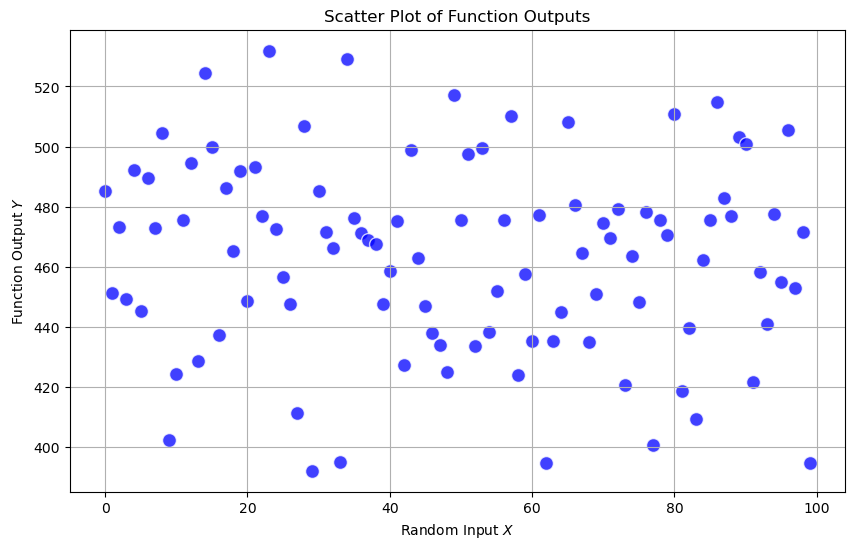

In [24]:
import numpy as np

# Define the existing arrays
N = 4
M = 3
alphas_1darray_m = np.array([0.3, 0.2, 0.1])
epsilon_2darray_mp = np.array(
    [
        [1, 2, 3, 4],
        [4, 5, 6, 7],
        [7, 8, 9, 10],
    ]
)


# Function to generate a random skew-symmetric matrix
def generate_skew_symmetric_matrix(N, seed=None):
    if seed is not None:
        np.random.seed(seed)
    X = np.random.randn(N, N)
    X = np.tril(X, -1) - np.tril(X, -1).T
    return X

Hs= []
# Varying the third array and generating the two-body tensor
num_variations = 100
X=[]
Y=[]
for i in range(num_variations):
    X.append(i)
    new_thetas = np.copy(thetas_3darray_mpq)
    for m in range(M):
        new_thetas[m] = generate_skew_symmetric_matrix(N, seed=i)
    
    # Construct the double factorized Hamiltonian
    two_body_tensor = construct_df_spatial_orbital(N, M, alphas_1darray_m, epsilon_2darray_mp, new_thetas)
    
    # Convert to physicist's notation
    h, V = convert_to_physicist(two_body_tensor)

    # sym_check = check_permutation_symmetries_real_orbitals(h,V)  # Demonstrate the eight-fold permutation symmetry of the two-body tensor is preserved
    # print(f"Permutation symmetries check passed: {sym_check}")
    H = of.FermionOperator()
    
    N = h.shape[0]  # Assuming h is an NxN matrix
    one_norm = 0.0
    # Add one-electron terms from matrix h
    for p in range(N):
        for q in range(N):
            if h[p][q] != 0:
                H += of.FermionOperator(((p, 1), (q, 0)), h[p][q])
                one_norm+=abs(h[p][q])
    
    # Add two-electron terms from tensor V
    for p in range(N):
        for q in range(N):
            for r in range(N):
                for s in range(N):
                    if V[p][q][r][s] != 0:
                        # Factor of 0.5 to compensate for double counting
                        H += of.FermionOperator(((p, 1), (q, 1), (r, 0), (s, 0)), 0.5 * V[p][q][r][s])
                        one_norm+=abs(0.5 * V[p][q][r][s])
                        

    Hs.append(H)
    Y.append(one_norm)

plt.figure(figsize=(10, 6))
plt.scatter(X, Y, color='blue', edgecolors='w', s=100, alpha=0.75)
plt.title('Scatter Plot of Function Outputs')
plt.xlabel('Random Input $X$')
plt.ylabel('Function Output $Y$')
plt.grid(True)
plt.show()

In [58]:
import cirq
import openfermion
from openfermion import InteractionOperator
from openfermion.circuits import trotter
from openfermion.transforms import get_interaction_operator

def create_controlled_trotter_circuit(hamiltonian: InteractionOperator, num_qubits: int, truncation_threshold: float = 1e-8, final_rank: int = None, spin_basis: bool = True):
    # Create the qubits for the system
    system_qubits = [cirq.NamedQubit(f'q{i}') for i in range(num_qubits)]
    
    # Add the control qubit
    control_qubit = cirq.NamedQubit('control')
    
    # Create the ControlledAsymmetricLowRankTrotterStep instance
    trotter_step = trotter.algorithms.low_rank.ControlledAsymmetricLowRankTrotterStep(
        hamiltonian=hamiltonian,
        truncation_threshold=truncation_threshold,
        final_rank=final_rank,
        spin_basis=spin_basis
    )
    
    return trotter_step


In [79]:
# Set Hamiltonian parameters for LiH simulation in active space.
diatomic_bond_length = 1.45
geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
basis = 'sto-3g'
multiplicity = 1
active_space_start = 1
active_space_stop = 3

# Generate and populate instance of MolecularData.
molecule = of.MolecularData(geometry, basis, multiplicity, description="1.45")
molecule.load()

# Get the Hamiltonian in an active space.
hamiltonian = molecule.get_molecular_hamiltonian(
    occupied_indices=range(active_space_start),
    active_indices=range(active_space_start, active_space_stop))
# Create the controlled trotter circuit
controlled_trotter_circuit = create_controlled_trotter_circuit(hamiltonian,final_rank=2, num_qubits=n_qubits)


circ=cirq.Circuit()
n_qubits = of.count_qubits(molecular_hamiltonian)
t=2.
qubits = cirq.LineQubit.range(n_qubits+1)
# H gate
circ+=cirq.H.on(qubits[0])

# CU(t, n_steps)
circ+=controlled_trotter_circuit.trotter_step(
    qubits=qubits[1:],
    time=t,
    control_qubit=qubits[0])

imag=True
if imag:
    circ+=cirq.S(qubits[0])**-1
    

# H gate
circ+=cirq.H.on(qubits[0])


circ+=cirq.measure(qubits[0], key='anc.')
print(len(circ))

47


In [81]:
print(circ.to_text_diagram(transpose=True))

  0         1             2                    3                4
  │         │             │                    │                │
  H         Rz(π)         Rz(π)                Rz(π)            Rz(π)
  │         │             │                    │                │
  │         │             PhISwap(0.25)────────PhISwap(0.25)^-1 │
  │         │             │                    │                │
  │         PhISwap(0.25)─PhISwap(0.25)^0.081  Z^0              │
  │         │             │                    │                │
  @─────────@^0.674       Z^0                  PhISwap(0.25)────PhISwap(0.25)^-0.081
  │         │             │                    │                │
  │         Rz(0)         PhISwap(0.25)────────PhISwap(0.25)^-1 Z^0
  │         │             │                    │                │
  @─────────┼─────────────@^0.674              Z^0              │
  │         │             │                    │                │
┌╴│         │             │                    │   